In [42]:
import numpy as np
from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import *
from astropy import table
from astropy.visualization import hist as ahist
from astropy.io import fits
from astropy import convolution
import os
from astropy.table import QTable, Table
from astropy import units as u
from astropy.coordinates import SkyCoord
import spectro as spec
from astropy.cosmology import Planck13 as cosmo
from matplotlib.patches import Ellipse
import spec_utils_alex as specu
from astropy.io import fits, ascii
from astropy.convolution import convolve, Box1DKernel
import numpy.ma as ma


In [43]:
from matplotlib import pyplot as plt
from matplotlib import rcParams, rc
from matplotlib.ticker import MultipleLocator, MaxNLocator

rc ('xtick',labelsize=15)
rc ('ytick',labelsize=15)
rc('font',family='serif', size=18)
rcParams['axes.linewidth'] = 1.5
rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (8,8)

In [44]:
csat='#ffb250'
chost='#992959'

In [45]:
directory = '/Users/ahamanowicz/Dropbox/COS-SAGA/Targets/'

In [46]:
haloid = 85746
helio_vel_host = 1457.0
lines = Table.read("../linelist_cos.txt", format='ascii')
lines.show_in_notebook()

idx,name,wav0,log(fl)
0,HI-1215,1215.7,2.704
1,FeII-1142,1142.36,0.661
2,FeII-1143,1143.23,1.432
3,FeII-1144,1144.94,1.978
4,SiII-1193,1193.2897,0.02
5,SiIII-1206,1206.5,0.01
6,SII-1250,1250.578,0.832
7,SII-1253,1253.805,1.136
8,SII-1259,1259.518,1.32
9,SiII-1260,1260.4221,3.171


In [47]:
#qso data
qso = Table.read("../85746-QSOdata.txt", format='csv')



In [48]:
qso.show_in_notebook()

idx,qso,original name,z_qso,b,RA_qso,DEC_qso
0,TON1129,TON1129,0.52611,209.222285927,149.0967254638672,32.60601806640625
1,J0958+3224,FBQSJ095820.9+322402,0.5306,13.4803426516,149.58726501464844,32.4006233215332
2,J0959+3203,SDSSJ095914.85+320357.2,0.56462,157.119171001,149.81187438964844,32.06591033935547


In [49]:
def continuum_fit_err(sightline,vel_sys,line_par,window_file, cont_min=-500, cont_max=500, order=3, save_spec=False, smooth=1):
   
    #line_par = [linewav,linename,log(fl)]
    #we stay in helio

    smoothing=convolution.Gaussian1DKernel(smooth) #COS smoothing
    ## coordinates
    vel = vel_sys

    ##spectrum file
    file='/Users/ahamanowicz/Dropbox/COS-SAGA/Targets/'+sightline+"/Data/"+sightline+"_nbin3_coadd.fits"
    hdul = fits.open(file)
   

    w = hdul['WAVELENGTH'].data
    fx = hdul['FLUX'].data
    es=hdul['ERROR'].data

    fs= fx#convolution.convolve(fx, smoothing)

    vel = vel_sys
    
    #get the line parameters 
    linename=line_par[1]
    line= line_par[0]
    line_f = float(line_par[2])
    
    print(sightline, linename)

    # continuum  fit
    #use plot_line_vel.py n to set the windows for fitting

    nanarray = np.isnan(fs) #mask nans in lfux
    notnan = ~ nanarray

    flux = fs[notnan]
    wav = w[notnan]
    err = es[notnan]
    
    #fit continuum around the line - move waveline to the redshift of the host
    wav_host = wav/(1+vel/3.e5)
    
    cont = spec.cont_fit(w=wav_host, f=flux, line=line, window_file=window_file,  degree = order, smooth = 1, outname = sightline+'_'+linename+'_fitting_cont_fit', plt_vmin = cont_min, plt_vmax =cont_max, outdir = './',spline=False, show=True)
    cont_err, cont_err_norm = specu.cont_fit_err(w=wav,f=flux,vsys=vel, line=line,window_file=window_file, nord=order, smooth=1, vlim_down=cont_min, vlim_up=cont_max )
    # continuum substraciton and spectral line cut
    ## continuum corrected
    wav_cont, cont_fit=cont[0], cont[1]
    
    #move to the velocity of the line
    flux_cont = flux/cont_fit
    err_norm = err/cont_fit
    
    vel_cut,flux_cont_cut = specu.cut_spec_window(wav, flux_cont, line=line, vel=vel_sys, veldown=cont_min,velup=cont_max)
    vel_cut,flux_err_cut = specu.cut_spec_window(wav, err_norm, line=line, vel=vel_sys, veldown=cont_min,velup=cont_max )
    
    if np.size(cont_err_norm) > np.size(flux_cont_cut):
        cont_err_norm = cont_err_norm[1:]
        print(np.size(cont_err_norm), np.size(flux_cont_cut))
    if np.size(cont_err_norm) < np.size(flux_cont_cut):
        flux_cont_cut = flux_cont_cut[1:]
        vel_cut =vel_cut[1:]
        flux_err_cut = flux_err_cut[1:]
        print(np.size(cont_err_norm), np.size(flux_cont_cut))
      
    data = np.stack((vel_cut,flux_cont_cut,flux_err_cut, cont_err_norm), axis=-1)
    ascii.write(data, sightline+'_'+linename+".dat", overwrite=True, names=('velocity','flux_norm','flux_err', "cont_err"))
    
        
    plt.figure(figsize=(12,7))
    
    plt.errorbar(vel_cut, flux_cont_cut, yerr=cont_err_norm,fmt='bo')
    plt.axhline(1.0,c='gray', ls='--') 
    plt.xlim([cont_min, cont_max])
    plt.ylim([0,1.5])
    
    plt.figure(figsize=(12,7))
    
    plt.plot(vel_cut, flux_cont_cut, 'k-')
    plt.axhline(1.0,c='gray', ls='--') 
    plt.xlim([cont_min, cont_max])
    plt.ylim([0,1.5])
    
    

## Load spectra anddo continuum fit


In [50]:
##DLA - J0958+3224
i=0
sightline =qso['qso'][i]
vel_sys = helio_vel_host
#line 
j=1
line_par = [lines['wav0'][j], lines['name'][j], lines['log(fl)'][j]]

window_file = sightline+"_cont_win_"+str(j)+".dat"
print(sightline, line_par[1])

TON1129 FeII-1142


In [51]:
# J0959+3203 SiIII-1206 

TON1129 FeII-1142
USING LEGENDRE


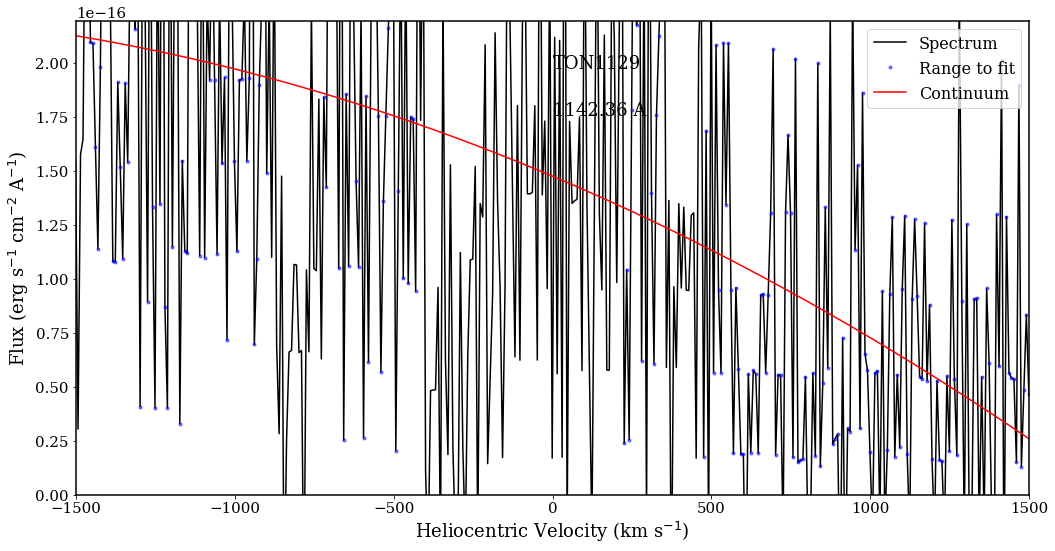

10922
381


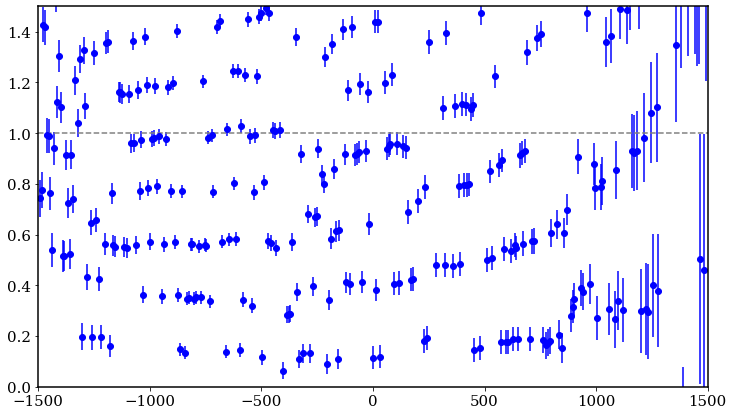

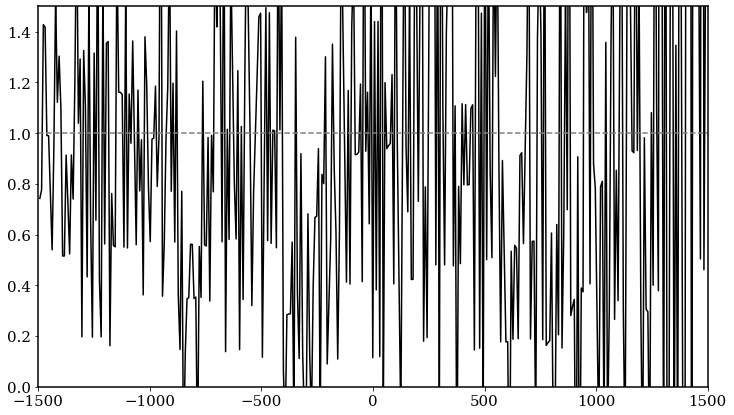

In [52]:
continuum_fit_err(sightline, vel_sys,line_par=line_par, smooth=3 ,order=2,
                  window_file=window_file, cont_min=-1500, cont_max=1500)


In [53]:
def eqw_simple(wav, flux, vmax, vmin,  nbins=100,line=0, plot=True):
    
    #returns the EQW in mA requires choice of the integration limits
    #takes in cut spectral window with the line at vel = 0
    
    
    #width of the bin in km/s
    dx = (vmax-vmin)/nbins #km/s
    #print(dx)
    grid = np.arange(vmin, vmax, dx)

    # sum the area of the line -> sum(1-f(x')) over x' being the value of the flux at the wavelength x'. sum in flux units
    eqw_sum=0
    x_ind=0

    for x in grid:
        for i in range(np.size(wav)-1):

             if x>= wav[i] and x <wav[i+1]:
                x_ind = i
                eqw_sum+= (1-flux[x_ind])
 

    eqw_field = eqw_sum*dx
    
    #height of the rectangle == continuum level c =1
    eqw = eqw_field/1.
    

    eqw = eqw/3.e5 *line # A
    
    a=np.where((wav >= -lim) & (wav <= lim))[0]
    
    if plot == True:
        fig=plt.figure(figsize=(12,8))
        plt.plot(vel, f, c='k', lw=2)
        
        plt.fill_between(wav[a], f[a],1,  fc='#b20000', step='mid', alpha=0.5)

        plt.xlim([-800, 800])
        plt.ylim([-0.1,2.0])
        plt.axhline(1, ls='--', c='grey')
        plt.axvline(0, ls=':', c='grey')

#         plt.axvline(-lim, ls='-', c='r')
#         plt.axvline(lim, ls='-', c='r')


        plt.xlabel("Velocity helio [km/s]")
        plt.ylabel("Normalized flux")

        plt.annotate("limits: "+str(vmin)+" "+str(vmax), (0.05,0.9),xycoords='axes fraction', fontsize=18)
        plt.annotate(r"W$_{r}$  = "+str(round(eqw, 3))+" $A$" , (0.05,0.85),xycoords='axes fraction', fontsize=18)

        plt.show()
        fig.savefig()
    
    return eqw

In [54]:
def AOD(vel,flux, flambda, vmin=-100, vmax=100):
        
    #AOD Savage+91 Na(v). Spectrum MUST be normalized to 1
            
    aod = np.log(1./flux)

    vrange = np.where((vel>vmin) &  (vel < vmax) & (np.isnan(aod)==False))[0]
   
    nav = aod*10.**(-1.*flambda)*10.**(14.576)

    delta = vmax-vmin
    noisem = np.where((vel>vmin-delta) & (vel< vmin) & (np.isnan(nav)==False) )[0]
    noisep = np.where((vel>vmax) & (vel < vmax+delta) & (np.isnan(nav)==False) )[0]

    na = np.trapz(nav[vrange], vel[vrange])
    noise  = 0.5*(np.std(nav[noisem]) +  np.std(nav[noisep]))
    noise_na = np.sqrt(len(vrange))*noise*np.median(np.abs(np.roll(vel[vrange],1)-vel[vrange]))
    logna =np.log10(na)
    noise_logna = noise_na/na/np.log(10.)

    mn = np.nanmin(nav[vrange])
    mx  = np.nanmax(nav[vrange])

    print("COLUMN ", logna, noise_logna)
    
    return logna, noise_logna #returns the log of N - integarted Na over the whole spec


In [55]:
def eqw_with_err(wav='', flux='', cont_err='', vellim=100 , velmask=0,linename='', linewav='',sightline='', nbins=100, xlim=250, plot=True):
    
    #automatically chooses the integration limits
    #returns the EQW in mA 
    #takes in cut spectral window with the line at vel = 0
    #velmax - choose the max velocity tested for integration limits
    #mean = initial limit for the gaussian fit, manipulate if fit doesnt converge
    c = 3.e5
    lambda0=linewav 
    cut=vellim
    if velmask == 0:
        final_eqw = eqw_simple(wav, flux, line=linewav, vmax=cut, vmin=-cut, nbins=nbins, plot=False)

    elif velmask > 0:
        final_eqw = eqw_simple(wav, flux, line=linewav, vmax=velmask, vmin=-cut, nbins=nbins, plot=False)
    elif velmask < 0:
        final_eqw = eqw_simple(wav, flux, line=linewav, vmax=cut, vmin=velmask, nbins=nbins, plot=False)
    cont_err[np.isnan(cont_err)] = 0
    #error
    E_sum = cont_err**2
    nx0 = np.size(flux)
    sigma = np.sqrt(np.sum((flux-1)**2)/(nx0-3-1))
    #chose the Eqw region
    i_min, i_max = min(np.where(wav>-cut)[0]), max(np.where(wav<cut)[0])

    cut_vel = wav[i_min:i_max]
    cut_flux = flux[i_min:i_max]

    #calculate the errors within the eqw range
    xs = max (np.abs(cut_vel))
    Xm = cut_vel/xs
    nx = np.size(Xm)
    dxi = (max(Xm)-min(Xm))/nx
    sigma_sum=0
    for i in range(i_min, i_max+1):

            sigma_sum+=E_sum[i] * (flux[i]**2)**2 * dxi**2 +   dxi**2    

    sigma_total = np.sqrt(sigma_sum) * sigma * xs * lambda0/c

    W_err = sigma_total
    
    print("W = "+str(round(final_eqw,3))+"+/-"+str(round( W_err,3)))
    if plot == True:
        fig = plt.figure( figsize=(8,8))
        plt.step(wav, flux, c='k')

        plt.fill_between(cut_vel, cut_flux,1,  fc='#b20000', step='pre')
        plt.annotate(sightline, (0.1, 0.95), xycoords='axes fraction', fontsize=16 )
        plt.annotate(linename+" "+str(linewav), (0.65, 0.95), xycoords='axes fraction', fontsize=16 )
        plt.annotate("W = "+str(round(final_eqw,1))+" +/- "+str(round( W_err,1)), (0.65, .9), xycoords='axes fraction', fontsize=16 )
        plt.axvline(cut, ls='--', c='gray')
        plt.axvline(-cut, ls='--', c='gray')
        plt.xlim([-xlim,xlim])
        plt.ylim([min(cut_flux)*0.5, 1.3])
        plt.xlabel("Velocity [km/s]", fontsize=15)
        plt.ylabel("Normalized flux", fontsize=15)
        fig.savefig(sightline+"_"+linename+"_"+str(linewav)+"_eqw.pdf")

    #run eqw again for the chosen limit value
    return final_eqw, W_err

In [56]:
#### EW measurements and AOD
measurement = open("85746-ew-measurements.txt", 'a')
i=0
sightline =qso['qso'][i]
vel_sys = helio_vel_host

s=2
j =15

linename=lines['name'][j]
line = lines['wav0'][j]
lf = lines['log(fl)'][j]
file=sightline+'_'+linename+".dat"
print(file, lf)

lim=150

data = np.loadtxt(file, skiprows=1) # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
vel, flux, err, cont_err = data.T[0], data.T[1], data.T[2], data.T[3]
f = convolve(flux, Box1DKernel(s))
plt.figure(figsize=(12,8))
plt.plot(vel, f, c='k', lw=2)
plt.xlim([-800, 800])
plt.ylim([-0.1,1.5])
plt.axhline(1, ls='--', c='grey')
plt.axvline(0, ls=':', c='grey')

plt.axvline(-lim, ls='-', c='r')
plt.axvline(lim, ls='-', c='r')


plt.xlabel("Velocity helio [km/s]")
plt.ylabel("Normalized flux")



IndexError: index 15 is out of bounds for axis 0 with size 15

In [ ]:
##3measurement

n = AOD(vel, flux, lf, vmin=-lim, vmax=lim)
eqw=eqw_with_err(vel, flux, cont_err, vellim=lim , linewav=line, velmask=0,nbins=100, xlim=800, plot=False)
print(n)

a=np.where((vel >= -lim) & (vel <= lim))[0]

fig=plt.figure(figsize=(12,8))
plt.plot(vel, f, c='k', lw=2)

plt.fill_between(vel[a], f[a],1,  fc='#b20000', step='mid', alpha=0.5)

plt.xlim([-800, 800])
plt.ylim([-0.1,2.0])
plt.axhline(1, ls='--', c='grey')
plt.axvline(0, ls=':', c='grey')


plt.xlabel("Velocity helio [km/s]")
plt.ylabel("Normalized flux")
plt.title(sightline)
plt.annotate("limits: "+str(-lim)+" "+str(lim), (0.05,0.95),xycoords='axes fraction', fontsize=18)
plt.annotate(r"W$_{r}$  = "+str(round(eqw[0], 3))+" +/- "+str(round(eqw[1], 3))+" $A$" , (0.05,0.9),xycoords='axes fraction', fontsize=18)
plt.annotate("log(N) = "+str(round(n[0], 2))+" +/- " + str(round(n[1],2)) , (0.05,0.85),xycoords='axes fraction', fontsize=18)
plt.annotate(linename, (0.85,0.9),xycoords='axes fraction', fontsize=18)

plt.show()
fig.savefig(sightline+'_'+linename+"_EW_N.png")


In [ ]:
measurement.write(sightline +" "+ linename +" "+ str(line) +" "+ str(lf) +" "+ str(lim)+ " "+ str(round(eqw[0], 3))+" "+ str(round(eqw[1], 3))+" "+str(round(n[0], 2))+" "+ str(round(n[1],2))+"\n" )
measurement.close()


In [ ]:
## plot al lines

fig, axs = plt.subplots(4,3, figsize=(15,17), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

mes = np.loadtxt('85746-ew-measurements.txt', dtype='str')

mm = np.where(mes.T[0] == sightline)
arr = mes[mm]
# sightline+'_'+linename+'_'+str(line)+".dat"
i=2
sightline =qso['qso'][i]
vel_sys = helio_vel_host

a=np.array([0])
b=np.arange(4,15,1)
c = np.append(a,b)

s=2
axs[0][1].set_title(sightline)

k,l=-1,-1
for i in c:
    l=i%3
    if i%3 ==0:
       
        k+=1
    linename=lines['name'][i]
    line = lines['wav0'][i]
    
    file=sightline+'_'+linename+".dat"
    
    nn = np.where(arr.T[1] == linename)
    W, Werr = arr[nn].T[5],float(arr[nn].T[6])
    print(Werr)
    Werr = str( 1.e3 * Werr)
    data = np.loadtxt(file, skiprows=1) # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
    vel, flux, err = data.T[0], data.T[1], data.T[2]
    f = convolve(flux, Box1DKernel(s))
    
    #choose the part used in EW calculations
    axs[k][l].plot(vel, f, c='k', lw=2)
    axs[k][l].set_xlim([-600, 600])
    axs[k][l].set_ylim([-0.1,2.0])
    axs[k][l].plot(vel, err, c='r', lw=2, alpha=0.5)
    
    axs[k][l].axhline(1,ls=':', color='gray', lw=2)
    axs[k][l].axvline(0,ls=':', color='gray', lw=2)

    axs[k][l].annotate( linename, (0.05, 0.9), xycoords='axes fraction', fontsize=16)#), (0.05, 0.1), xycoords='axes fraction', fontsize=16 )
    
    if W[0] == '-99' :
        axs[k][l].annotate( "W = --", (0.05, 0.8), xycoords='axes fraction', fontsize=16)#), (0.05, 0.1), xycoords='axes fraction', fontsize=16 )
    elif "<" in W[0]:
        axs[k][l].annotate( "W "+W[0], (0.05, 0.8), xycoords='axes fraction', fontsize=16)#), (0.05, 0.1), xycoords='axes fraction', fontsize=16 )

    else:
        axs[k][l].annotate( "W = "+W[0]+" +/- "+Werr[0], (0.05, 0.8), xycoords='axes fraction', fontsize=16)#), (0.05, 0.1), xycoords='axes fraction', fontsize=16 )

    axs[k][l].xaxis.set_minor_locator(MultipleLocator(50))
    axs[k][l].xaxis.set_major_locator(MultipleLocator(200))
    
    axs[k][l].tick_params(which='major', direction='in', length=12, width=2)
    axs[k][l].tick_params(which='minor', direction='in', length=6, width=2)
    
axs[3][1].set_xlabel("Velocity [km/s]", fontsize=22)   
    #plt.title(line +" "+ str(line0)+ " "+ lines.T[3][k])
# k = np.where((vel0 > -vlim ) & (vel0< vlim))[0]

#axs[i].plot(vel0[k], f[k], c='red', lw=3)
# axs[i].fill_between(vel0[k], f[k],1,  fc='red', step='pre')

    
# #chose the Wr for print on plot
# d = np.where(ta['linewav'] == line0)[0]
# print(d)
# W, W_err = ta['Wr'][d][0], ta['Wr_err'][d][0]

# axs[i].annotate( line+ " " + str(int(line0))+"\nW = "+str(round(W,1))+" +/- "+str(round( W_err,1)), (0.05, 0.1), xycoords='axes fraction', fontsize=16 )
# axs[i].axvline(vlim, ls='--', c='gray')
# axs[i].axvline(-vlim, ls='--', c='gray')
# axs[i].axhline(1, ls=':', c='gray')

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:>]
0
0 0 0
TON1129_HI-1215.dat
1
1 0 1
TON1129_FeII-1142.dat
2
2 0 2
TON1129_FeII-1143.dat
3
3 1 0
TON1129_FeII-1144.dat
4
4 1 1
TON1129_SiII-1193.dat
5
5 1 2
TON1129_SiIII-1206.dat
6
6 2 0
TON1129_SII-1250.dat
7
7 2 1
TON1129_SII-1253.dat
8
8 2 2
TON1129_SII-1259.dat
9
9 3 0
TON1129_SiII-1260.dat
10
10 3 1
TON1129_OI-1302.dat
11
11 3 2
TON1129_SiII-1304.dat
12
12 4 0
TON1129_CII-1334.dat
13
13 4 1
TON1129_SiIV-1393.dat
14
14 4 2
TON1129_SiIV-1402.dat


Text(0.5, 0, 'Velocity [km/s]')

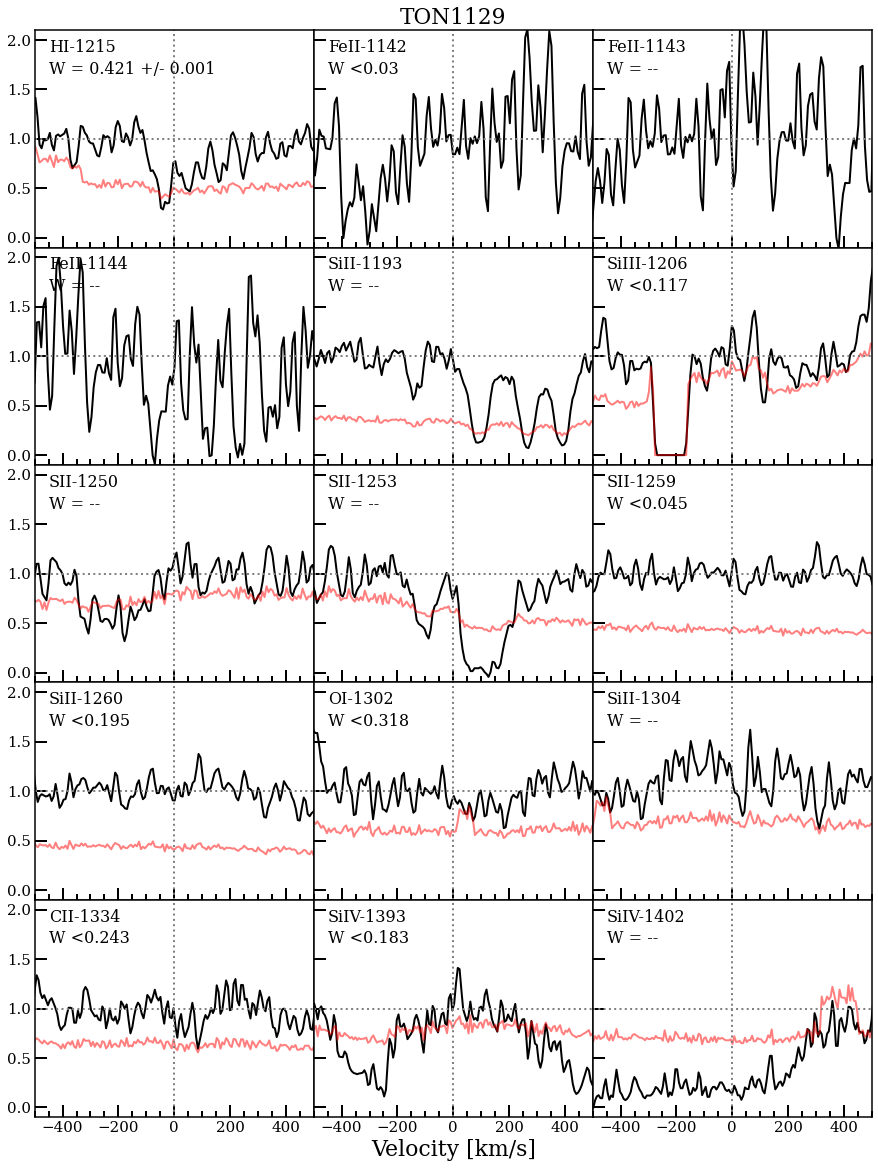

In [57]:
## plot al lines

fig, axs = plt.subplots(5,3, figsize=(15,20), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

# sightline+'_'+linename+'_'+str(line)+".dat"
print(axs.T[0])
i=0
sightline =qso['qso'][i]
vel_sys = helio_vel_host
mes = np.loadtxt('85746-ew-measurements.txt', dtype='str')

mm = np.where(mes.T[0] == sightline)
arr = mes[mm]
s=2
k,l=-1,-1
axs[0][1].set_title(sightline)


for i in range(15):
    print(i)
    l=i%3
    if i%3 ==0:
       
        k+=1

    print(i,k,l)
    linename=lines['name'][i]
    line = lines['wav0'][i]
    
    file=sightline+'_'+linename+".dat"
    print(file)
    nn = np.where(arr.T[1] == linename)
    W, Werr = arr[nn].T[5],arr[nn].T[6]
    
    data = np.loadtxt(file, skiprows=1) # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
    vel, flux, err = data.T[0], data.T[1], data.T[2]
    f = convolve(flux, Box1DKernel(s))
    
    #choose the part used in EW calculations
    axs[k][l].plot(vel, f, c='k', lw=2)
    axs[k][l].set_xlim([-500,500])
    axs[k][l].set_ylim([-0.1,2.1])
    axs[k][l].plot(vel, err, c='r', lw=2, alpha=0.5)
    
    axs[k][l].axhline(1,ls=':', color='gray', lw=2)
    axs[k][l].axvline(0,ls=':', color='gray', lw=2)

    axs[k][l].annotate( linename, (0.05, 0.9), xycoords='axes fraction', fontsize=16)#), (0.05, 0.1), xycoords='axes fraction', fontsize=16 )
    if W[0] == '-99' :
        axs[k][l].annotate( "W = --", (0.05, 0.8), xycoords='axes fraction', fontsize=16)#), (0.05, 0.1), xycoords='axes fraction', fontsize=16 )
    elif "<" in W[0]:
        axs[k][l].annotate( "W "+W[0], (0.05, 0.8), xycoords='axes fraction', fontsize=16)#), (0.05, 0.1), xycoords='axes fraction', fontsize=16 )

    else:
        axs[k][l].annotate( "W = "+W[0]+" +/- "+Werr[0], (0.05, 0.8), xycoords='axes fraction', fontsize=16)#), (0.05, 0.1), xycoords='axes fraction', fontsize=16 )
    axs[k][l].xaxis.set_minor_locator(MultipleLocator(50))
    axs[k][l].xaxis.set_major_locator(MultipleLocator(200))
    
    axs[k][l].tick_params(which='major', direction='in', length=12, width=2)
    axs[k][l].tick_params(which='minor', direction='in', length=6, width=2)

axs[4][1].set_xlabel("Velocity [km/s]", fontsize=22)   

    
    #plt.title(line +" "+ str(line0)+ " "+ lines.T[3][k])
# k = np.where((vel0 > -vlim ) & (vel0< vlim))[0]

#axs[i].plot(vel0[k], f[k], c='red', lw=3)
# axs[i].fill_between(vel0[k], f[k],1,  fc='red', step='pre')

    
# #chose the Wr for print on plot
# d = np.where(ta['linewav'] == line0)[0]
# print(d)
# W, W_err = ta['Wr'][d][0], ta['Wr_err'][d][0]

# axs[i].annotate( line+ " " + str(int(line0))+"\nW = "+str(round(W,1))+" +/- "+str(round( W_err,1)), (0.05, 0.1), xycoords='axes fraction', fontsize=16 )
# axs[i].axvline(vlim, ls='--', c='gray')
# axs[i].axvline(-vlim, ls='--', c='gray')
# axs[i].axhline(1, ls=':', c='gray')

Text(0.5, 0, 'Distance form the host [kpc]')

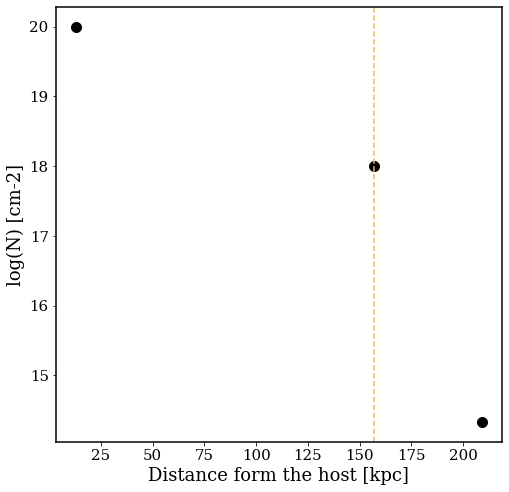

In [58]:
logN = np.array([20.0, 18, 14.33])
b = np.array([13,157,209])
plt.plot(b, logN, 'ko', ms=10)

#satellite 
bsat = 157
plt.axvline(bsat, ls='--', c=csat)
plt.ylabel("log(N) [cm-2]")
plt.xlabel("Distance form the host [kpc]")

In [59]:
vsat=34.21 #km/s


In [60]:
## how much gas is in the dwarf that size?
logms = 6.07
def gasmass(mstar):
    #from Blanton+ 2018
    #mstar in log
    if mstar <= 8.6:
        mgas = 1.052 * mstar + 0.236
    else:
        mgas = 0.461 * mstar + 5.329
    return mgas

In [61]:
gasmass(logms)

6.62164

In [73]:
from astropy import units as u

#velocity on the circular orbit
# v = sqrt (GM/R)
R = 157*u.kpc #kpc
R_m = R.to(u.m) # in meters
print(R_m)

#mass
M_host = 10**(11.8231) *u.M_sun
M_h_kg= M_host.to(u.kg)

4.844513802903491e+21 m


In [74]:
print(R_m, M_h_kg)


4.844513802903491e+21 m 1.32314033975113e+42 kg


In [75]:
from astropy.constants import G

In [76]:
print(G)

  Name   = Gravitational constant
  Value  = 6.6743e-11
  Uncertainty  = 1.5e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2018


In [77]:
v = np.sqrt( G * M_h_kg/R_m)
print(v.to(u.km/u.s)) # orbital velocit at the position of the satellite

R = np.linspace(1, 600, 600)*u.kpc

Rm = R.to(u.m)
v_Esc = np.sqrt(2* G * M_h_kg/Rm)
print(v_Esc.to(u.km/u.s))

135.01459505567115 km / s
[2392.46471985 1691.72802715 1381.29015003 1196.23235992 1069.94274947
  976.71963187  904.26666703  845.86401358  797.48823995  756.56377363
  721.35525454  690.64507501  663.55032478  639.41309226  617.73173442
  598.11617996  580.25792621  563.90934238  548.86904946  534.97137473
  522.07860363  510.07519213  498.86337921  488.35981594  478.49294397
  469.20093431  460.43005001  452.13333351  444.26954523  436.80229836
  429.6993486   422.93200679  416.47465039  410.30431446  404.40034745
  398.74411997  393.31877711  388.10902686  383.10095863  378.28188682
  373.64021548  369.16532094  364.84744935  360.67762727  356.64758316
  352.74967833  348.97684602  345.32253751  341.78067426  338.34560543
  335.01206989  331.77516239  328.63030315  325.57321062  322.59987701
  319.70654613  316.88969346  314.14600811  311.47237644  308.86586721
  306.32371808  303.84332326  301.42222234  299.05808998  296.74872654
  294.49204948  292.28608547  290.1289631   288.018

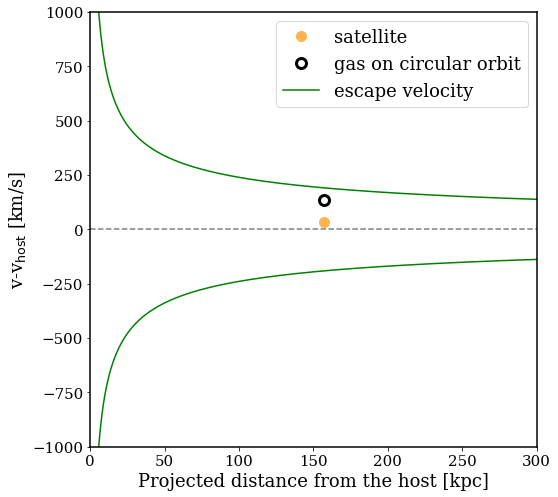

In [78]:
plt.plot(bsat*u.kpc, vsat*(u.km/u.s), 'o',c=csat, ms=10, label='satellite')
plt.xlim([0,300])

# plt.plot(0,0, c=chost)
# print(R)
plt.plot(157*u.kpc,v.to(u.km/u.s), 'o', ms=10,markerfacecolor='none', markeredgewidth=3, markeredgecolor='k', label='gas on circular orbit' )
plt.axhline(0, ls='--', color='gray')
plt.plot(R, v_Esc.to(u.km/u.s), c='green', label='escape velocity')
plt.plot(R, -v_Esc.to(u.km/u.s), c='green')
plt.ylim([-1000,1000])
plt.xlabel("Projected distance from the host [kpc]")
plt.ylabel(r"v-v$_{\rm host}$ [km/s]")
plt.legend()


In [79]:
v = np.sqrt( G * M_h_kg/R_m)
print(v.to(u.km/u.s)) # orbital velocit at the position of the satellite

R = np.linspace(1, 600, 600)*u.kpc

Rm = R.to(u.m)
v_Esc = np.sqrt(2* G * M_h_kg/Rm)
v = np.sqrt(G* M_h_kg/Rm)

135.01459505567115 km / s


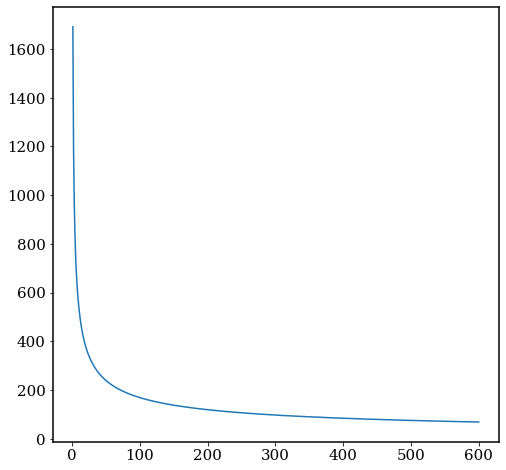

In [69]:
plt.plot(R.to(u.kpc),v.to(u.km/u.s))

(0.0, 200.0)

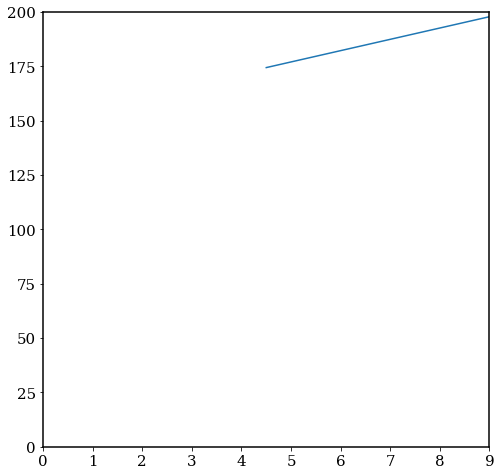

In [70]:
r = np.linspace(4.5,10)
a = 5.2
b = 151
va = a * r+b
plt.plot(r,va)
plt.xlim([0,9])
plt.ylim([0,200])
